# Imports and helper functions

In [4]:
path_to_PSM = "/home/rezvan/Documents/Clustered-Pix2Pix/"

from keras.datasets import mnist
import numpy as np
from tqdm import tqdm
np.random.seed(10)
import statistics
#!pip install pydot
#!pip install graphviz
from time import time
import random
import pandas as pd
import networkx as nx
from datetime import datetime
import shutil
import numpy as np
from collections import defaultdict
from sklearn.cluster import KMeans
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
import random
import matplotlib.cm as cm
import community.community_louvain as community_louvain
import scipy.io
from sklearn.model_selection import train_test_split
import cv2
import ast
import re
import itertools
import json


def save_dict_to_file(dct, file_save):
    with open(file_save, 'w') as f:
        for key, value in dct.items():
            f.write('%s:%f\n' % (key, value))



def copy_to_folder(src_dir, dst_dir, files_list, extension):
    if not os.path.isdir(dst_dir):
        os.makedirs(dst_dir)
    for file in files_list:  
        name = os.path.join(src_dir, file + extension)
        if os.path.isfile( name ) :
            shutil.copy( name, dst_dir)
        else :
            print('file does not exist', name)



    
def average_all_images_given_clustering_pytorch_pix2pix(imglist,groups,filepath , univ_folder, train_or_test_or_val):
    print(train_or_test_or_val)
    for img in tqdm(imglist):
        avg_dict = average_image_cluster(img,[360,640],groups)
        for cluster_num in avg_dict:
            dst_path_B = filepath +"/"+ str(cluster_num) +"/B/"+ train_or_test_or_val
            universal_path = f"{path_to_PSM}Universal Saliency/{univ_folder}/"
            pathA = universal_path 
            dst_path_A = filepath + "/"+str(cluster_num) + "/A/" + train_or_test_or_val
            
            if not os.path.isdir(dst_path_A):
                    os.makedirs(dst_path_A)
                
            if not os.path.isdir(dst_path_B):
                os.makedirs(dst_path_B)
                
                
            im = Image.fromarray(avg_dict[cluster_num])
            im = im.convert("L")
            im.save(dst_path_B + img+"jpg")
            image_A = cv2.imread(pathA + img + "jpg",0)
            image_A = cv2.resize(image_A, (640,360), interpolation = cv2.INTER_AREA) 
            cv2.imwrite(dst_path_A + img + "jpg", image_A)



#this function returns the average of an image for individuals in each cluster, 
#output is dictionary of cluster -> avg saliency images
#cluster_to_user is a dictionary which keys are cluster numbers 
#and values are the user index that is in that cluster
def average_image_cluster(img,img_size, cluster_to_user):
    result_dict = {}    
  
    for group in cluster_to_user:
        num_add = len(cluster_to_user[group])
        avg_img = np.zeros((img_size[0],img_size[1]))
        for i in cluster_to_user[group]:
           
            avg_img = np.add(avg_img,np.array(Image.open(path_to_PSM+'Dataset/fixation_map_30_release/Sub_' + str(i+1) +"/"+img+"png" ).convert('L'))[:img_size[0],:img_size[1]]) 
            
        avg_img = np.divide(avg_img, num_add)
        result_dict[group] = avg_img
    return result_dict


def partition_to_dict(partition):
    dct_result = defaultdict(list)
    for i in partition:
        dct_result[partition[i]].append(int(i))
    return dct_result


def dict_to_partition(dct):
    partition = {}
    for i in dct:
        for j in dct[i]:
            partition[j] =  i
    return partition



def create_avg_fixation(path, datetime_cl):
    
    path_to_cl = path + datetime_cl
    txt_content = open(path_to_cl+ "/Clustering Logs "+str(datetime_cl)+'.txt', "r").read()
    dict_text = re.findall(r'{(?:[^{}])*}',txt_content)[0]
    pardict = ast.literal_eval(dict_text)
    for cl in tqdm(pardict):
        
        all_images_cl = defaultdict(list)
        for subj in pardict[cl]:
            df = scipy.io.loadmat(f"/Users/rezvansherkati/Desktop/Clustering_files/Dataset/fixData/ImfixData_Sub_{subj+1}.mat") 
            for i in range(len(df["ImfixDataALL"][0])):
                x_s = [item for sublist in df["ImfixDataALL"][0][i][0][0][2] for item in sublist]
                y_s = [item for sublist in df["ImfixDataALL"][0][i][0][0][3] for item in sublist]
                all_images_cl[df["ImfixDataALL"][0][i][0][0][0][0].lower().replace(" ", "").replace("]","").replace("[","").replace("#","").replace("(","").replace(")","").replace(",","").replace("'","")]+=list(zip(x_s,y_s))
        
        fix_path = path_to_cl + "/fixations/" +str(cl) + "/"
        if not os.path.isdir(fix_path):
                os.makedirs(fix_path)
        for img_name in all_images_cl:
            mat = np.matrix(all_images_cl[img_name])
            save_df = pd.DataFrame(data=mat)
            if img_name[:-4][-1] == ".":
                save_df.to_csv(fix_path+ img_name[:-4]+'csv', header=False, index=False)
                

            else:
                save_df.to_csv(fix_path+ img_name[:-4]+'.csv', header=False, index=False)

        

        
def create_all_fixation(dict_path):
    
    
    clustering_name = dict_path.split("/")[-1]
    txt_file = f"Clustering Logs {clustering_name}.txt"
    txt_content = open(join(dict_path,txt_file), "r").read()
    dict_text = re.findall(r'{(?:[^{}])*}',txt_content)[0]
    
    cluster_dct = ast.literal_eval(dict_text)
    
    if not os.path.isdir(dict_path+ "/fixations"):
      os.makedirs(dict_path+ "/fixations")
    
    for cl in tqdm(cluster_dct):
        fix_path = dict_path + "/fixations/" +str(cl) + "/"
        if not os.path.isdir(fix_path):
            os.makedirs(fix_path)
        for subj in cluster_dct[cl]:
            all_images_cl = defaultdict(list)
            df = scipy.io.loadmat(f"/Users/rezvansherkati/Desktop/Clustering_files/Dataset/fixData/ImfixData_Sub_{subj+1}.mat") 
            for i in range(len(df["ImfixDataALL"][0])):
                x_s = [item for sublist in df["ImfixDataALL"][0][i][0][0][2] for item in sublist]
                y_s = [item for sublist in df["ImfixDataALL"][0][i][0][0][3] for item in sublist]
                all_images_cl[df["ImfixDataALL"][0][i][0][0][0][0].lower().replace(" ", "").replace("]","").replace("[","").replace("#","").replace("(","").replace(")","").replace(",","").replace("'","")]+=list(zip(x_s,y_s))

    
            for img_name in all_images_cl:
                mat = np.matrix(all_images_cl[img_name])
                save_df = pd.DataFrame(data=mat)
                if img_name[:-4][-1] == ".":
                    save_df.to_csv(fix_path + str(subj)+"-" + img_name[:-4]+'csv', header=False, index=False)
 

                else:
        
                    save_df.to_csv(fix_path + str(subj)+"-" + img_name[:-4]+'.csv', header=False, index=False)

    
#reads properties of individuals of PSM dataset from .mat file and returns an array
#of array of properties of each person
def read_properties(path, feature_type = ["gender", "color", "sport", "other", "fashion"], ind_list = np.arange(30)):
    demo = scipy.io.loadmat(path)
    
    type_dict = {'sex' : 'gender', 'it':'other', 'auto':'sport', 'fashion' : 'fashion', 'eat':'other', 'sport':'sport', 
                 'reading':'other', 'plant':'other', 'red (like)' : 'color', 'yellow (like)': 'color', 'green (like)': 'color',
                 'cyan (like)': 'color', 'blue (like)': 'color', 'purple (like)': 'color', 'white (like)': 'color', 
                 'black (like)': 'color', 'red (dislike)': 'color', 'yellow (dislike)': 'color', 
                 'green (dislike)': 'color', 'cyan (dislike)': 'color', 'blue (dislike)': 'color',
                 'purple (dislike)': 'color', 'white (dislike)': 'color', 'black (dislike)': 'color', 
                 'basketball':'sport', 'football':'sport', 'badminton':'sport', 'tabletennis':'sport', 
                 'tennis':'sport', 'volleyball':'sport', 'baseball':'sport', 'billiards':'sport', 'chess':'sport', 
                 'ring': 'fashion', 'necklace': 'fashion', 'bracelet': 'fashion', 'earring': 'fashion', 'hairpin': 'fashion',
                 'watch': 'fashion', 'glasses': 'fashion', 'tie': 'fashion', 'belt': 'fashion', 'kneelet': 'fashion'}
    

    
    dictlist =[]
    for ppl in ind_list:
        ind = ppl+1
        temp =[]
        for i in range(1,len(demo['personal_data_with_title'][ind])):
            if type_dict[demo['personal_data_with_title'][0][i][0]] in feature_type:
                temp.append(demo['personal_data_with_title'][ind][i][0][0])
                

        dictlist.append(temp)
    dictlist = np.array(dictlist).astype(int)
    return [p[0] for p in demo['personal_data_with_title'][0][1:]], dictlist



# Clustering 

In [8]:

def network_avg_euc_with_varying_weight_features(images_list, path_to_PSM, feature_weight_categories=[0,0,0,0,0], feature_type= ["gender", "color", "sport", "other", "fashion"], ind_list = np.arange(30), base_path = None):
    if base_path is None:
        network = nx.Graph()
    else:
        network = nx.read_weighted_edgelist(base_path)


    titles_gender, prop_arr_gender = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"), feature_type = ["gender"], ind_list = ind_list)
    titles_color , prop_arr_color = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"), feature_type = ["color"], ind_list = ind_list)
    titles_sport , prop_arr_sport = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"), feature_type = ["sport"], ind_list = ind_list)
    titles_other , prop_arr_other = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"), feature_type = ["other"], ind_list = ind_list)
    titles_fashion , prop_arr_fashion = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"), feature_type = ["fashion"], ind_list = ind_list)


    list_prop_arrs = [prop_arr_gender, prop_arr_color, prop_arr_sport, prop_arr_other, prop_arr_fashion]
    for i in range(len(ind_list)-1):
        for i2 in range(i+1,len(ind_list)):
            pers = ind_list[i]
            pers2 = ind_list[i2]
            acc_distance = 0
            counter_distance = 0
            if base_path is None:
                for im_counter in range(len(images_list)):

                    im1 = images_list[im_counter]
                    temp_arr1 = np.array(Image.open(join(path_to_PSM,'Dataset/res_64_fixation_map_30_release/Sub_' + str(pers+1) +"/"+im1+"png" )).convert('L'))/255
                    temp_arr2 = np.array(Image.open(join(path_to_PSM,'Dataset/res_64_fixation_map_30_release/Sub_' + str(pers2+1) +"/"+im1+"png" )).convert('L'))/255


                    acc_distance += (np.sum(np.abs(temp_arr1 - temp_arr2)) + 1)/(temp_arr1.shape[0]* temp_arr1.shape[1])
                    counter_distance +=1.

                network.add_edge(str(pers),str(pers2), weight = counter_distance/acc_distance)



            for cnt, feature_arr in enumerate(list_prop_arrs):

                feat1_flat = np.array(feature_arr[i])#.flatten()
                feat2_flat = np.array(feature_arr[i2])#.flatten()
                f_weight = feature_weight_categories[cnt]

                euc_feat_distance =  ((np.sum(np.abs(feat1_flat- feat2_flat))+1)/len(feat1_flat)).astype('float')


                if network.has_edge(str(pers),str(pers2)):
                    network[str(pers)][str(pers2)]['weight'] +=f_weight/euc_feat_distance
                else:
                    network.add_edge(str(pers),str(pers2), weight=f_weight/euc_feat_distance)


    return network



#this function visualizes a network
def vis_network(network,partition, filename, disp_highest= True):
    pos = nx.spring_layout(network)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    labels = {}    
    for node in network.nodes():
      
        #set the node name as the key and the label as its value 
        labels[node] = int(node)+1
    color_list = ["pink","y", "g","m","c"]
    width_arr = [] 

    
    node_a = sorted(network.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[0][0]
    node_b = sorted(network.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[0][1]
    ed_color = []
    for ed in list(network.edges):
        if sorted(list(ed)) == sorted([node_a,node_b]):
            if disp_highest:
                ed_color.append("r")
                width_arr.append(5)
            else:
                ed_color.append("dimgray")
                width_arr.append(0.3)
        else:
            ed_color.append("dimgray")
            width_arr.append(0.3)
    
    plt.figure(figsize=(7.0, 5.0))
    plt.axis('off')
    
    nx.draw_networkx_nodes(network, pos,nodelist = partition.keys(), node_size=300,
                           cmap=cmap, node_color=[color_list[i] for i in list(partition.values())])
    
    nx.draw_networkx_labels(network,pos,labels, font_size=11,font_color="k")
    
    nx.draw_networkx_edges(network, pos, width = width_arr,edge_color = ed_color ,alpha=0.8)
   
    plt.savefig( path_to_PSM + f"Network Visualizations/{filename}.pdf", format="pdf")
    


In [19]:

onlyfiles = [f[:-3] for f in listdir(path_to_PSM + "Universal Saliency/DGIIE_univ_results/") if isfile(join(path_to_PSM + "Universal Saliency/DGIIE_univ_results/" , f))]
for i in range(1,31):
    onlyfiles= list(set(onlyfiles) & set([f[:-3] for f in listdir(path_to_PSM + "Dataset/fixation_map_30_release/Sub_" + str(i) +"/") if isfile(join(path_to_PSM + "Dataset/fixation_map_30_release/Sub_" + str(i) +"/" , f))]))


X_train_val, X_test = train_test_split(onlyfiles, test_size=0.20, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.20, random_state=42)

with open(path_to_PSM+"pytorch_pix2pix_experiment/X_train.txt", 'w') as f:
    f.write(str(X_train))

with open(path_to_PSM+"pytorch_pix2pix_experiment/X_val.txt", 'w') as f:
    f.write(str(X_val))

with open(path_to_PSM+"pytorch_pix2pix_experiment/X_test.txt", 'w') as f:
    f.write(str(X_test))

In [20]:

# X_train_context = open(join(path_to_PSM,"X_train.txt"), "r").read()
# X_train = ast.literal_eval(X_train_context)
#
# X_val_context = open(join(path_to_PSM, "X_val.txt"), "r").read()
# X_val = ast.literal_eval(X_val_context)
#
# X_test_context = open(join(path_to_PSM,"X_test.txt"), "r").read()
# X_test = ast.literal_eval(X_test_context)

# images_all_list = X_train

# Main dataset generation functions

In [23]:
def avg_create_files_pytorch_pix2pix( X_train,X_val, X_test,inp_pardict, from_existing_clustering, datetime_cl, feature_weight, feature_type, univ_names_dict, universal_number, pre_path = "", path_to_files="" ):
    
    mypath = path_to_PSM + "Dataset/fixation_map_30_release/Sub_1"
    base_path = path_to_PSM +"Dataset/all_images_release/"
    sal_path = path_to_PSM +"Dataset/fixation_map_30_release/"

    universal_cluster = univ_names_dict[universal_number][0]
    if from_existing_clustering:
        path_to_cl = path_to_PSM + "DG2/" + datetime_cl
        txt_content = open(path_to_cl+ "/Clustering Logs "+str(datetime_cl)+'.txt', "r").read()
        dict_text = re.findall(r'{(?:[^{}])*}',txt_content)[0]
        pardict = ast.literal_eval(dict_text)
        partition = dict_to_partition(pardict)
    else:
        pardict = inp_pardict

    print(pardict)
    
    if from_existing_clustering:
        dt_string = datetime_cl
        path_save = path_to_PSM + pre_path+"/"+ universal_cluster + "/"+ path_to_files + "/" + str(dt_string)
        if not os.path.isdir(path_save):
            os.makedirs(path_save)
        with open(path_save+ "/Clustering Logs "+str(dt_string)+'.txt', 'w+') as f:
            f.write(txt_content)
    else:
        now = datetime.now()
        dt_string = now.strftime("%d-%m-%Y_%Hh%Mm%Ss")

        path_save = path_to_PSM + pre_path+"/"+ universal_cluster + "/"+ path_to_files + "/" + str(dt_string)

        if not os.path.isdir(path_save):
            os.makedirs(path_save)

        with open(path_save+ "/Clustering Logs "+str(dt_string)+'.txt', 'w+') as f:
            f.write(str(pardict))
            f.write("\n")
            f.write(f"feature_weight = {feature_weight} \n")
            f.write(f"feature_type = {str(feature_type)}")


    

    univ_folder = univ_names_dict[universal_number][1]
    print(univ_folder)
    universal_path = f"{path_to_PSM}Universal Saliency/{univ_folder}/"
    
    
    copy_to_folder(universal_path, path_save+"/testA/", X_test, "jpg")
    average_all_images_given_clustering_pytorch_pix2pix(X_test, pardict, path_save , univ_folder, "test/")
    average_all_images_given_clustering_pytorch_pix2pix(X_val, pardict, path_save , univ_folder, "val/")
    average_all_images_given_clustering_pytorch_pix2pix(X_train, pardict, path_save , univ_folder, "train/")
    
    if not os.path.isdir(path_save + "/results/"):
        os.makedirs(path_save + "/results/")

    
    with open(path_save+ "/pix_"+universal_cluster+ "_"+str(dt_string)+'.sh', 'w+') as f:
        f.write("#!/bin/bash \n")
        f.write(f"MYPATH=./datasets/dataset_pytorch_pix2pix/{pre_path}/{universal_cluster}/{path_to_files}/{dt_string}/")

        for i in range(len(pardict)):
            f.write("\n")
            f.write(f"python3 train.py --dataroot ${{MYPATH}}{i} --name {universal_cluster}_{dt_string}/{i} --model pix2pix --display_id -1")
            # f.write(f"python pix2pixgan_datagen.py --mode train --dataset_name {universal_cluster}/{dt_string} --cl_num {i}" )
            f.write("\n")
            f.write(f"python3 test.py --dataroot ${{MYPATH}}{i} --model pix2pix --name {universal_cluster}_{dt_string}/{i} ")
            # f.write(f"python pix2pixgan_datagen.py --mode test --dataset_name {universal_cluster}/{dt_string} --cl_num {i}")
            

    return pardict, dt_string

In [25]:
def create_mean_feature_vec(cluster_dct):
    titles, prop_arr = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"))
    avg_features = defaultdict(list)

    for cl in cluster_dct:

        all_features= []
        for p in cluster_dct[cl]:
            all_features.append(prop_arr[p])

        avg_features[cl] = np.mean(all_features, axis=0)
    return avg_features



def avg_euc_same_images_all_settings(X_train,X_val, X_test, path_for_save,mode, which_modul, ind_list = np.arange(30),from_network = False):

    all_features = ["gender", "sport", "color", "other", "fashion"]


    weights_to_try = [1,2,4,8]

    if not os.path.isdir(join(path_to_PSM, path_for_save)):
        os.makedirs(join(path_to_PSM, path_for_save))
    with open(join(path_to_PSM, path_for_save,"train_subjects.txt"), 'w+') as f:
        f.write(str(ind_list))
    comb_weights =  list(itertools.product(weights_to_try, weights_to_try, weights_to_try,weights_to_try,weights_to_try))
    modularity_dict= dict()
    pardict_dict = dict()
    if not os.path.exists(path_to_PSM + f"{path_for_save}/Networks/sett_(0, 0, 0, 0, 0)/"):
        os.makedirs(path_to_PSM + f"{path_for_save}/Networks/sett_(0, 0, 0, 0, 0)/")
        network= network_avg_euc_with_varying_weight_features(X_train, path_to_PSM, (0, 0, 0, 0, 0) , all_features, ind_list)

        nx.write_weighted_edgelist(network, path_to_PSM + f"{path_for_save}/Networks/sett_(0, 0, 0, 0, 0)/net (0, 0, 0, 0, 0).adjlist")

    for i, weight_list in tqdm(enumerate(comb_weights)):
        if from_network or not os.path.exists(path_to_PSM + f"{path_for_save}/Networks/sett_{weight_list}/"):


            f_type = all_features
            # if from_base:
            #     network = add_feature_weight_to_network(path_for_save, n_clusters, path_to_PSM, f_weight, f_type, ind_list = np.arange(30))
            # else:
            if from_network:
                network = nx.read_weighted_edgelist(path_to_PSM + f"{path_for_save}/Networks/sett_{weight_list}/net {weight_list}.adjlist")
            else:
                if weight_list == (0,0,0,0,0):
                    network= network_avg_euc_with_varying_weight_features(X_train, path_to_PSM, weight_list , f_type, ind_list)
                else:
                    network= network_avg_euc_with_varying_weight_features(X_train, path_to_PSM, weight_list , f_type, ind_list, base_path = path_to_PSM + f"{path_for_save}/Networks/sett_(0, 0, 0, 0, 0)/net (0, 0, 0, 0, 0).adjlist" )

            save_network = path_to_PSM + f"{path_for_save}/Networks/sett_{weight_list}/"
            if not os.path.isdir(save_network):
                os.makedirs(save_network)

            if not from_network:
                nx.write_weighted_edgelist(network, save_network + f"net {weight_list}.adjlist")
            partition = community_louvain.best_partition(network, weight='weight')
            modularity = community_louvain.modularity(partition, network)
            modularity_dict[str(weight_list)] =modularity
            pardict = partition_to_dict(partition)
            pardict_dict[str(weight_list)] = pardict

    if which_modul == "max":
        # print(modularity_dict)
        wanted_value = max(modularity_dict.values())
    if which_modul == "min":
        wanted_value = min(modularity_dict.values())
    if which_modul == "10thmax":
        sorted_modul = sorted(modularity_dict.values(), reverse=True)
        wanted_value = sorted_modul[9]

    wanted_comb = ""
    for key, value in modularity_dict.items():
        if value == wanted_value:
            wanted_comb = key
            print(wanted_comb)
    pardict = pardict_dict[wanted_comb]
    print(f"{which_modul} modularity : ", wanted_comb)

    generate_files_from_dict(X_train,X_val, X_test, pardict, path_for_save, f'{mode}_{which_modul}_{wanted_comb.replace(" ", "").replace(",", "").replace("(", "").replace(")", "")}', mode,  feature_weights = wanted_comb )
    return wanted_comb


In [26]:
def generate_files_from_dict(X_train,X_val, X_test,pardict, path_for_save, sett_name, mode, univ_list = [2,3,4], feature_weights="", half_batch_size=100):

    all_features = ["gender", "sport", "color", "other", "fashion"]
#

    n_clusters = len(pardict)
    f_weight = -1
    main_run_text = ""
    data_gen_text = ""

    f_type = all_features

    save_network = path_to_PSM + f"{path_for_save}/Networks/sett_{sett_name}"
    if not os.path.isdir(save_network):
        os.makedirs(save_network)


    print(pardict)
    with open(save_network+ f"/Clustering Logs {sett_name}.txt", 'w+') as f:
        f.write(str(pardict))
        f.write("\n")
        f.write(f"Categories feature weights: {str(feature_weights)} \n")



    from_existing_clustering = False
    datetime_cl = ""
    univ_names_dict = {1: ["DG2", "deepgazeII_density_results"], 2:["DGIIE", "DGIIE_result_density"] , 3: ["MLNet", "mlnet_univ_results"] , 4: ["SalGAN", "salgan_univ_results"]}

    for universal_number in univ_list:

        if mode == "pix2pix":

            pardict, dt_string = avg_create_files_pytorch_pix2pix( X_train,X_val, X_test,pardict, from_existing_clustering, datetime_cl, f_weight, f_type, univ_names_dict, universal_number, pre_path = path_for_save, path_to_files=f"sett_{sett_name}")

            path_save = "./datasets/dataset_pytorch_pix2pix/" + path_for_save+"/"+ univ_names_dict[universal_number][0] + "/"+ f"sett_{sett_name}" + "/" + str(dt_string)
            # main_run_text += f"bash {path_save}/pix_{univ_names_dict[universal_number][0]}_{str(dt_string)}.sh \n"
            main_run_text += f"python3 train.py --dataroot ./datasets/dataset_pytorch_pix2pix/{path_for_save}/{univ_names_dict[universal_number][0]}/sett_{sett_name}/{str(dt_string)} --name {univ_names_dict[universal_number][0]}_{sett_name}_{str(dt_string)} --model pix2pix --display_id -1 --num_clusters {n_clusters} --batch_size 16 --n_epochs {half_batch_size} --n_epochs_decay {half_batch_size}\n"
            main_run_text += f"python3 test.py --dataroot ./datasets/dataset_pytorch_pix2pix/{path_for_save}/{univ_names_dict[universal_number][0]}/sett_{sett_name}/{str(dt_string)} --name {univ_names_dict[universal_number][0]}_{sett_name}_{str(dt_string)} --model pix2pix --num_clusters {n_clusters}\n"
            for mykey in list(pardict.keys()):
                data_gen_text+= f"python datasets/combine_A_and_B.py --fold_A {path_save}/{str(mykey)}/A --fold_B {path_save}/{str(mykey)}/B --fold_AB {path_save}/{str(mykey)} \n"

    if mode == "pix2pix":
        now = datetime.now()
        mytime = now.strftime("%d-%m-%Y_%Hh%Mm%Ss")
        with open(path_to_PSM + path_for_save+ f'/data_and_main_run_{sett_name}_{mytime}.sh', 'w+') as f:
            f.write("#!/bin/bash \n")
            f.write(data_gen_text)
            f.write(main_run_text)



In [27]:
def generate_5_split_files(path_for_save, universal_path):
    onlyfiles = [f[:-3] for f in listdir(path_to_PSM + universal_path) if isfile(join(path_to_PSM + universal_path , f))]
    for i in range(1,31):
        onlyfiles= list(set(onlyfiles) & set([f[:-3] for f in listdir(path_to_PSM + "Dataset/fixation_map_30_release/Sub_" + str(i) +"/") if isfile(join(path_to_PSM + "Dataset/fixation_map_30_release/Sub_" + str(i) +"/" , f))]))

    for i in range(5):
        Xi_train_val, Xi_test = train_test_split(onlyfiles, test_size=0.20)
        Xi_train, Xi_val = train_test_split(Xi_train_val, test_size=0.20)

        if not os.path.isdir(join(path_to_PSM, path_for_save+ f"/split_{i}")):
            os.makedirs(join(path_to_PSM, path_for_save+ f"/split_{i}"))

        with open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_train.txt", 'w') as f:
            f.write(str(Xi_train))

        with open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_val.txt", 'w') as f:
            f.write(str(Xi_val))

        with open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_test.txt", 'w') as f:
            f.write(str(Xi_test))

        avg_euc_same_images_all_settings(Xi_train,Xi_val, Xi_test, path_for_save+f"/split_{i}",mode="pix2pix", which_modul='max', ind_list = np.arange(30),from_network = False)

In [28]:
generate_5_split_files("Clustered_pix2pix_files/new_5_split", "Universal Saliency/DGIIE_univ_results/")

# Other experiment generation functions

In [29]:
def generate_experiments_files(path_for_save, X_train, X_val, X_test, mode, sett_name, code_mode, univ_list ):

    if mode == "30clusters":
        pardict = {i:[i] for i in range(30)}
    if mode == "random":
        n_clusters = 3
        pardict = defaultdict(list)
        s = np.random.uniform(0,1,30)
        for counter, nm in enumerate(s):
            cl_temp = int(nm// (1./n_clusters))
            pardict[cl_temp].append(counter)
    if mode == "1cluster":

        pardict = {0:list(np.arange(30))}
    generate_files_from_dict(X_train,X_val, X_test, pardict, path_for_save, sett_name, code_mode, univ_list = univ_list )


In [30]:
def generate_univ2avgPSM_from_current_split(path_for_save, mode):
    for i in range(5):
        X_train_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_train.txt", "r").read()
        X_train = ast.literal_eval(X_train_context)

        X_val_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_val.txt", "r").read()
        X_val = ast.literal_eval(X_val_context)

        X_test_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_test.txt", "r").read()
        X_test = ast.literal_eval(X_test_context)
        generate_experiments_files(f"{path_for_save}/split_{i}/one_cluster", X_train, X_val, X_test, mode = "1cluster", sett_name = "One_cluster_splits", code_mode = mode, univ_list = [3,4])

def generate_experiment_from_current_splits(path_for_save, mode ):
    pardict1 = defaultdict(list)
    n_clusters= 3
    s = np.random.uniform(0,1,30)
    for counter, nm in enumerate(s):
        cl_temp = int(nm// (1./n_clusters))
        pardict1[cl_temp].append(counter)
    for i in range(5):
        X_train_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_train.txt", "r").read()
        X_train = ast.literal_eval(X_train_context)

        X_val_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_val.txt", "r").read()
        X_val = ast.literal_eval(X_val_context)

        X_test_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_test.txt", "r").read()
        X_test = ast.literal_eval(X_test_context)

        generate_files_from_dict(X_train,X_val, X_test, pardict1, path_for_save = f"{path_for_save}/split_{i}/same_random_clusters", sett_name = "same_random_cluster_splits", mode= mode, univ_list = [2])

        generate_experiments_files(f"{path_for_save}/split_{i}/one_cluster", X_train, X_val, X_test, mode = "1cluster", sett_name = "One_cluster_splits", code_mode = mode, univ_list = [2,3,4])
        generate_experiments_files(f"{path_for_save}/split_{i}/30_clusters", X_train, X_val, X_test, mode = "30clusters", sett_name = "30_clusters_splits", code_mode = mode, univ_list = [2])
        generate_experiments_files(f"{path_for_save}/split_{i}/random_clusters", X_train, X_val, X_test, mode = "random", sett_name = "random_clusters_splits", code_mode = mode, univ_list = [2])



In [31]:
def generate_files_from_path_dict(X_train,X_val, X_test, path_src_dict, path_for_save, mode, dir_to_copy = "DGIIE", univ_list = [2, 3,4]):

    for root, dirs, files in os.walk(join(path_src_dict, dir_to_copy)):
        print("Current Directory:", root)

        # Iterate over files in the current directory
        for file in files:
            if "Clustering Logs" in file:
                print("File:", os.path.join(root, file))
                txt_content = open( os.path.join(root, file), "r").read()
                dict_text = re.findall(r'{(?:[^{}])*}',txt_content)[0]
                pardict = ast.literal_eval(dict_text)

        # Iterate over subdirectories in the current directory
        for directory in dirs:
            if directory.startswith("sett_"):
                sett_name = directory[5:]
                print("sett_name: ", sett_name)
        #     print("Subdirectory:", os.path.join(root, directory))
    if not pardict:
        print(f"No Clustering logs found in {path_src_dict}!")
        return
    if not sett_name:
        print("No setting name found!")
        return
    if dir_to_copy == "DGIIE":
        var_path_for_save = path_for_save
    else:
        var_path_for_save = join(path_for_save, dir_to_copy)
    generate_files_from_dict(X_train,X_val, X_test, pardict, path_for_save = var_path_for_save, sett_name = sett_name, mode= mode, univ_list = univ_list)



def generate_prev_clustered_from_current_splits(source_path, path_for_save, mode ):

    for i in range(5):
        X_train_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_train.txt", "r").read()
        X_train = ast.literal_eval(X_train_context)

        X_val_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_val.txt", "r").read()
        X_val = ast.literal_eval(X_val_context)

        X_test_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_test.txt", "r").read()
        X_test = ast.literal_eval(X_test_context)

        generate_files_from_path_dict(X_train,X_val, X_test, f"{path_to_PSM}{source_path}/split_{i}/" , f"{path_for_save}/split_{i}/" , mode, dir_to_copy="random_clusters")



In [22]:
def make_files_for_feat_weight(X_train, path_for_save, chosen_weight):
    str_weight = str(chosen_weight).replace(" ","").replace("(","").replace(")","").replace(",","").replace("[","").replace("]","")

    network = network_avg_euc_with_varying_weight_features(X_train, path_to_PSM, feature_weight_categories= chosen_weight)
    save_network = path_to_PSM + f"{path_for_save}/Networks/sett_{str_weight}"
    if not os.path.isdir(save_network):
        os.makedirs(save_network)
    nx.write_weighted_edgelist(network, join(save_network, f"net_{str_weight}.adjlist"))
    partition = community_louvain.best_partition(network, weight='weight')
    pardict = partition_to_dict(partition)
    generate_files_from_dict(X_train,X_val, X_test,pardict, path_for_save, sett_name = f"{str_weight}", mode = "pix2pix", univ_list = [2], feature_weights = chosen_weight, half_batch_size=100 )

# Files generation 20 train, 10 test setting experiment

In [25]:
def generate_clusters_20_train_10_test(X_train,X_val, X_test, path_for_save):
    cluster_ppl = random.sample(range(30), 20)
    chosen_weight = avg_euc_same_images_all_settings(X_train,X_val, X_test, path_for_save,mode = "pix2pix", which_modul="max", ind_list = cluster_ppl,from_network = False)
    return chosen_weight


In [26]:
def generate_clusters_20_train_10_test_current_splits(path_for_save):
    cluster_ppl = random.sample(range(30), 20)
    for i in range(5):
        print("Split ", i)
        X_train_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_train.txt", "r").read()
        X_train = ast.literal_eval(X_train_context)

        X_val_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_val.txt", "r").read()
        X_val = ast.literal_eval(X_val_context)

        X_test_context = open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_test.txt", "r").read()
        X_test = ast.literal_eval(X_test_context)


        avg_euc_same_images_all_settings(X_train,X_val, X_test, f"{path_for_save}/split_{i}/20train_10test",mode = "pix2pix", which_modul="max", ind_list = cluster_ppl,from_network = False)




In [28]:
def generate_clusters_20_train_10_test_new_splits(path_for_save):

    onlyfiles = [f[:-3] for f in listdir(path_to_PSM + "Universal Saliency/deepgazeII_density_results/") if isfile(join(path_to_PSM + "Universal Saliency/deepgazeII_density_results/" , f))]
    for i in range(1,31):
        onlyfiles= list(set(onlyfiles) & set([f[:-3] for f in listdir(path_to_PSM + "Dataset/fixation_map_30_release/Sub_" + str(i) +"/") if isfile(join(path_to_PSM + "Dataset/fixation_map_30_release/Sub_" + str(i) +"/" , f))]))

    cluster_ppl = random.sample(range(30), 20)
    for i in range(5):
        Xi_train_val, Xi_test = train_test_split(onlyfiles, test_size=0.20, random_state=42)
        Xi_train, Xi_val = train_test_split(Xi_train_val, test_size=0.20, random_state=42)

        if not os.path.isdir(join(path_to_PSM, path_for_save+ f"/split_{i}")):
            os.makedirs(join(path_to_PSM, path_for_save+ f"/split_{i}"))

        with open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_train.txt", 'w') as f:
            f.write(str(Xi_train))

        with open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_val.txt", 'w') as f:
            f.write(str(Xi_val))

        with open(f"{path_to_PSM}{path_for_save}/split_{i}/X{i}_test.txt", 'w') as f:
            f.write(str(Xi_test))

        avg_euc_same_images_all_settings(Xi_train,Xi_val, Xi_test, f"{path_for_save}/split_{i}/20train_10test_new_splits",mode = "pix2pix", which_modul="max", ind_list = cluster_ppl,from_network = False)

# New person assignment for 20subjs for train, 10 subjs for test setting experiment

In [30]:
#THIS APPROACH IS USED IN THE PAPER
def new_person_assigment_20train_10test(path, feature_weight_categories):
    print("**************************** ", path, " ***********************************")
    path_to_PSM = "/home/rezvan/Documents/Saliency/"
    ext_result = "png"

    chosen_cluster_metrics = defaultdict(list)
    other_cluster_metrics = defaultdict(list)



    clust_files_path = join(path_to_PSM, path)
    folder_name = path.split("/")[-1]
    txt_file = f"Clustering Logs {folder_name}.txt"
    txt_content = open(join(clust_files_path,txt_file), "r").read()
    dict_text = re.findall(r'{(?:[^{}])*}',txt_content)[0]
    cluster_dct = ast.literal_eval(dict_text)
    ind_list = [item for sublist in cluster_dct.values() for item in sublist]
    indiv_to_test = [i for i in range(30) if i not in ind_list]

    tested_files = [f[:-3] for f in listdir(join(clust_files_path,"0/B/test" )) if isfile(join(clust_files_path,"0/B/test" , f))]
    titles_all, prop_arr_all = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"))
    titles_gender, prop_arr_gender = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"), feature_type = ["gender"])
    titles_color , prop_arr_color = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"), feature_type = ["color"])
    titles_sport , prop_arr_sport = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"), feature_type = ["sport"])
    titles_other , prop_arr_other = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"), feature_type = ["other"])
    titles_fashion , prop_arr_fashion = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"), feature_type = ["fashion"] )
    list_prop_arrs = [prop_arr_gender, prop_arr_color, prop_arr_sport, prop_arr_other, prop_arr_fashion]

    avg_features = defaultdict(list)
    avg_features_gender = defaultdict(list)
    avg_features_color = defaultdict(list)
    avg_features_sport = defaultdict(list)
    avg_features_other = defaultdict(list)
    avg_features_fashion = defaultdict(list)
    features_clusters_scores = defaultdict(float)

    if not os.path.exists(join(clust_files_path, f"new_person_stat_{str(feature_weight_categories).replace(' ','')}")):
            os.makedirs(join(clust_files_path, f"new_person_stat_{str(feature_weight_categories).replace(' ','')}"))

    for cl in cluster_dct:

        all_features= []
        gender_temp = []
        color_temp = []
        sport_temp=[]
        other_temp = []
        fashion_temp = []
        for p in cluster_dct[cl]:
            all_features.append(prop_arr_all[p])
            gender_temp.append(prop_arr_gender[p])
            color_temp.append(prop_arr_color[p])
            sport_temp.append(prop_arr_sport[p])
            other_temp.append(prop_arr_other[p])
            fashion_temp.append(prop_arr_fashion[p])

        avg_features[cl] = np.mean(all_features, axis=0)
        avg_features_gender[cl] = np.mean(gender_temp, axis=0)
        avg_features_color[cl] = np.mean(color_temp, axis=0)
        avg_features_sport[cl] = np.mean(sport_temp, axis=0)
        avg_features_other[cl] = np.mean(other_temp, axis=0)
        avg_features_fashion[cl] = np.mean(fashion_temp, axis=0)
    all_avg_features = [avg_features_gender, avg_features_color, avg_features_sport, avg_features_other, avg_features_fashion]

    for pers in indiv_to_test:
        clusters_scores = defaultdict(float)

        for i2 in cluster_dct:

            acc_distance = 0
            counter_distance = 0
            for im_counter in range(len(tested_files)):
                im1 = tested_files[im_counter]

                temp_arr1 = np.array(Image.open(join(path_to_PSM,'Dataset/fixation_map_30_release/Sub_' + str(pers+1) +"/"+im1+"png" )).convert('L'))[:640,:360]/255
                temp_arr2 = np.array(Image.open(join(clust_files_path,str(i2), "B/test",im1+"jpg" )).convert('L'))[:640,:360]/255

                acc_distance += (np.sum(np.abs(temp_arr1 - temp_arr2)) + 1)/(temp_arr1.shape[0]* temp_arr1.shape[1])
                counter_distance +=1.


            clusters_scores[i2]+= counter_distance/acc_distance

            for cnt, feature_arr in enumerate(list_prop_arrs):

                feat_pers = np.array(feature_arr[pers])#.flatten()
                feat_cluster = np.array(all_avg_features[cnt][i2])#.flatten()
                # print(len(feature_arr[i]))
                f_weight = feature_weight_categories[cnt]


                euc_feat_distance =  (np.sum(np.abs(feat_pers- feat_cluster))+1)/len(feat_cluster)
                clusters_scores[i2] +=f_weight/euc_feat_distance




    ##################################################################

        save_dict_to_file(clusters_scores, join(clust_files_path, f"new_person_stat_{str(feature_weight_categories).replace(' ','')}",f"{pers}_salcloseness.txt"))
        max_link = str(max(clusters_scores, key=clusters_scores.get))

        txt_file = f"{pers}_train20_test10_perf.txt"
        txt_content = open(join(clust_files_path,txt_file), "r").read()
        txt_content = txt_content.replace("defaultdict(<class 'float'>, ", "")
        txt_content = txt_content.replace(")", "")
        junk = re.findall(r"defaultdict\(<function pytorch_eval_one_person_train20_test10.<locals>.<lambda> at \w*>, ", txt_content )[0]
        txt_content = txt_content.replace(junk, "")
        acc_dict = ast.literal_eval(txt_content)

        for key in acc_dict:
            if key == max_link:
                for mtr in acc_dict[key]:
                    chosen_cluster_metrics[mtr].append(acc_dict[key][mtr])
            else:
                for mtr in acc_dict[key]:
                    other_cluster_metrics[mtr].append(acc_dict[key][mtr])



    chosen_metrics = dict()
    other_metrics = dict()
    # if display_std_metrics:
    print("***************** chosen std dev ************************")
    for key1 in chosen_cluster_metrics:
        print(key1, np.std(chosen_cluster_metrics[key1]))
        chosen_metrics[key1] = float("{:.4f}".format(np.mean(chosen_cluster_metrics[key1])))
        print(chosen_metrics[key1], "$\pm$", float("{:.4f}".format(np.std(chosen_cluster_metrics[key1])) ))
    print("******************** other std dev ********************")
    for key2 in other_cluster_metrics:
        print(key2) #, np.std(other_cluster_metrics[key2]))
        other_metrics[key2] = float("{:.4f}".format(np.mean(other_cluster_metrics[key2])))
        print(other_metrics[key2], "$\pm$", float("{:.4f}".format(np.std(other_cluster_metrics[key2])) ))



    average_all_cl = {}
    print("AVERAGE OF ALL CLUSTERS: ")
    for key3 in other_cluster_metrics:
        average_all_cl[key3] = float("{:.4f}".format(np.mean(chosen_cluster_metrics[key3] + other_cluster_metrics[key3])))
        print(average_all_cl[key3], "$\pm$", float("{:.4f}".format(np.std(chosen_cluster_metrics[key3] + other_cluster_metrics[key3])) ))

    save_dict_to_file(chosen_metrics, join(clust_files_path,f"new_person_stat_{str(feature_weight_categories).replace(' ','')}", f"highest_links_chosen_metrics.txt"))
    save_dict_to_file(other_metrics, join(clust_files_path,f"new_person_stat_{str(feature_weight_categories).replace(' ','')}",f"highest_links_other_metrics.txt"))


    print("Average of all the clusters: \n", average_all_cl )
    print("chosen_metrics: ", chosen_metrics)
    print("other_metrics: ", other_metrics)
    with open(os.path.join(clust_files_path, "chosen_metrics.txt"), "w") as file:
        json.dump(chosen_metrics, file)
    with open(os.path.join(clust_files_path, "other_metrics.txt"), "w") as file:
        json.dump(other_metrics, file)
    return chosen_metrics, other_metrics

In [8]:
def average_20_10_experiments_splits(mode, splits_path, name_res_file):
    key_sums = {}

    print("***************** " , mode, name_res_file," *************************")
    splits_num = 5
    num_dicts = splits_num
    for i in range(splits_num):
        temp_dir = os.path.join(splits_path, f"split_{i}", mode)
        items = os.listdir(temp_dir)

        # Filter out folders from the list
        folders = [item for item in items if os.path.isdir(os.path.join(temp_dir, item))]
        temp_dir_2 = os.path.join(temp_dir, folders[0])
        items2 = os.listdir(temp_dir_2)

        # Filter out folders from the list
        folders2 = [item for item in items2 if os.path.isdir(os.path.join(temp_dir_2, item))]
        results_path = os.path.join(temp_dir_2, folders2[0])
        res_files = [f_path for f_path in os.listdir(results_path) if name_res_file in f_path ]
        file_path = os.path.join(results_path, res_files[0])
        with open(file_path, 'r') as file:
            dict_res = json.load(file)
            for key, value in dict_res.items():
                key_sums.setdefault(key, 0)
                key_sums[key] += value
    key_averages = {key: value / num_dicts for key, value in key_sums.items()}

    print(key_averages)



In [7]:
def average_scores_splits_by_mode(mode, splits_path):
    num_files = 0
    print("***************** " , mode, " *************************")
    entry_sums = [0, 0, 0, 0]  # Initialize sum variables for each entry
    scores_average = defaultdict(lambda: [0, 0, 0, 0])
    all_splits_scores = defaultdict(lambda: defaultdict(list))
    for i in [0,1,2,3,4,5]:
        temp_dir = os.path.join(splits_path, f"split_{i}", mode)
        items = os.listdir(temp_dir)
        print(f"------- Split {i} ---------")

        # Filter out folders from the list
        folders = [item for item in items if os.path.isdir(os.path.join(temp_dir, item))]
        temp_dir_2 = os.path.join(temp_dir, folders[0])
        items2 = os.listdir(temp_dir_2)

        # Filter out folders from the list
        folders2 = [item for item in items2 if os.path.isdir(os.path.join(temp_dir_2, item))]
        results_path = os.path.join(temp_dir_2, folders2[0], "results")
        res_files = [f_path for f_path in os.listdir(results_path) if "multi_pix_General_perf" in f_path ]
        file_path = os.path.join(results_path, res_files[0])
        with open(file_path, 'r') as file:
            for line in file:
                entries = line.strip().split('&')
                name = entries[0].strip()
                print(name)
                tmp_str = ""

                for i, entry in enumerate(entries[1:]):
                    entry = re.sub('\s+', ' ', entry)
                    entry_value = float(entry.strip().split(" ")[0])
                    tmp_str += str(entry_value) + "     "
                    all_splits_scores[name][i].append(entry_value)
                    scores_average[name][i] += entry_value
                print(tmp_str)
        num_files += 1
    print("####### Average of splits: ############")
    for key in scores_average:
        averages = [entry_sum / num_files for entry_sum in scores_average[key]]
        scores_average[key] = averages
        print(key)
        temp_str =""
        for kk in averages:
            temp_str+=" &"+ str("{:.4f}".format(kk))
        print(temp_str)

    print("Averages:")

    print(scores_average)
    names_scores = ["CC", "SIM", "AUC", "NSS"]
    for key in all_splits_scores:
        for sc in all_splits_scores[key]:
            print(key, names_scores[sc], np.var(all_splits_scores[key][sc]))




# Draw Network

In [46]:
def draw_spec_network(path_to_net, net_num):
    i = net_num
    network = nx.read_weighted_edgelist(path_to_PSM + f"{path_to_net}/Networks/sett_{i}/net {i}.adjlist")

    txt_content = open(path_to_PSM + f"{path_to_net}/Networks/sett_{i}/Clustering Logs {i}.txt", "r").read()
    dict_text = re.findall(r'{(?:[^{}])*}',txt_content)[0]
    clusters_dict = ast.literal_eval(dict_text)

    partition = clusterdict_to_partition(clusters_dict)
    #         print(partition)
    # color the nodes according to their partition


    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


    labels = {}
    for node in network.nodes():

        #set the node name as the key and the label as its value
        labels[node] = int(node)+1
    color_list = ["pink","y", "g","m","c"]
    width_arr = []

    node_a = sorted(network.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[0][0]
    node_b = sorted(network.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[0][1]
    ed_color = []
    for ed in list(network.edges):
        if sorted(list(ed)) == sorted([node_a,node_b]):
            ed_color.append("r")
            width_arr.append(0.9)
        else:
            ed_color.append("gray")
            width_arr.append(0.5)

    #         plt.figure(figsize=(7.0, 5.0))

    # ix = np.unravel_index(i, ax.shape)
    # plt.sca(ax[ix])
    plt.figure(figsize=(7.0, 5.0))
    plt.axis('off')
    pos = nx.spring_layout(network)
    nx.draw_networkx_nodes(network, pos,nodelist = partition.keys(), node_size=200,
                           cmap=cmap, node_color=[color_list[i] for i in list(partition.values())])

    nx.draw_networkx_labels(network,pos,labels, font_size=10,font_color="k")

    nx.draw_networkx_edges(network, pos, width = width_arr, edge_color = ed_color ,alpha=0.7)
    plt.savefig( path_to_PSM + f"{path_to_net}/NetVis_{net_num}.eps",format="eps", bbox_inches='tight',pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


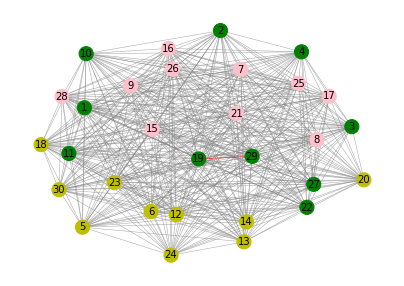

In [47]:
# draw_spec_network("Clustering_distance_approach/L1_avg_clustering", (1,1,1,1,8))

In [33]:
def clusterdict_to_partition(dct):
    partition = {}
    for i in dct:
        for j in dct[i]:
            partition[str(j)] =  i
    return partition

def vis_ensemble_network(experim_folder, list_settings):
    fig, ax = plt.subplots(2, 4, figsize=(15,8))
    # ax[-1, -1].axis('off')

    for i in list_settings:
        network = nx.read_weighted_edgelist(path_to_PSM + f"{experim_folder}/Networks/sett_{i}/net {i}.adjlist")

        txt_content = open(path_to_PSM + f"{experim_folder}/Networks/sett_{i}/Clustering Logs {i}.txt", "r").read()
        dict_text = re.findall(r'{(?:[^{}])*}',txt_content)[0]
        clusters_dict = ast.literal_eval(dict_text)

        partition = clusterdict_to_partition(clusters_dict)
#         print(partition)
        # color the nodes according to their partition


        cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


        labels = {}
        for node in network.nodes():

            #set the node name as the key and the label as its value
            labels[node] = int(node)+1
        color_list = ["pink","y", "g","m","c"]
        width_arr = []

        node_a = sorted(network.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[0][0]
        node_b = sorted(network.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[0][1]
        ed_color = []
        for ed in list(network.edges):
            if sorted(list(ed)) == sorted([node_a,node_b]):
                ed_color.append("r")
                width_arr.append(5)
            else:
                ed_color.append("gray")
                width_arr.append(0.05)

#         plt.figure(figsize=(7.0, 5.0))

        ix = np.unravel_index(i, ax.shape)
        plt.sca(ax[ix])
        pos = nx.spring_layout(network)
        nx.draw_networkx_nodes(network, pos,nodelist = partition.keys(), node_size=200,
                               cmap=cmap,ax=ax[ix], node_color=[color_list[i] for i in list(partition.values())])

        nx.draw_networkx_labels(network,pos,labels, ax=ax[ix], font_size=10,font_color="k")

        nx.draw_networkx_edges(network, pos, width = width_arr, ax=ax[ix], edge_color = ed_color ,alpha=0.7)
        ax[ix].title.set_text(f'Setting {i}')
#         plt.axis('off')


    plt.savefig( path_to_PSM + f"{experim_folder}/Networks/ensemble.eps", format="eps", bbox_inches='tight',pad_inches = 0)



# Stats code

In [82]:
def pixelwise_SM_std_person_maps(file_save, to_normalize = False, save_images_mode = False, average_SM_needed = False):
    all_images_path = path_to_PSM +"Dataset/all_images_release/"
    all_images_names = [f[:-3] for f in listdir(all_images_path) if isfile(join(all_images_path, f))]
    for i in range(1,31):
        all_images_names= list(set(all_images_names) & set([f[:-3] for f in listdir(path_to_PSM + "Dataset/fixation_map_30_release/Sub_" + str(i) +"/") if isfile(join(path_to_PSM + "Dataset/fixation_map_30_release/Sub_" + str(i) +"/" , f))]))

    dict_mean_std = dict()
    processed_img = [f[:-3] for f in listdir(path_to_PSM + "std_per_image") if isfile(join(path_to_PSM + "std_per_image/", f))]
    processed_img_joint = [f[:-3] for f in listdir(path_to_PSM + "std_per_image_joint") if isfile(join(path_to_PSM + "std_per_image_joint/", f))]

    fileout = open("html-table-standard-dev.html", "w")

    table = "<style type=\"text/css\" > \n img { \n width: 500px; height: 250 \n }\n table, th, td { \n border: 1px solid black; \n } \n </style> \n <table style=\"width:100%\">\n   <tr> \n <th>Image Name</th> \n <th>Stimuli</th> \n <th>Avg Saliency Map</th> \n <th>Avg Standard Dev</th> \n <th>Mean Standard Dev</th> \n </tr>"


    for image_name in tqdm(all_images_names):
        # if image_name not in processed_img or image_name not in processed_img_joint:
        if average_SM_needed:
            groups = {0:list(np.arange(30))}
            avg_dict = average_image_cluster(image_name,[360,640],groups)

            for cluster_num in avg_dict:
                dst_path_B = "average_SM/"
                if not os.path.isdir(dst_path_B):
                    os.makedirs(dst_path_B)

                im = Image.fromarray(avg_dict[cluster_num])
                im = im.convert("L")
                im.save(dst_path_B + image_name+"png")

        all_persons = []
        for i in range(30):
            image_i = np.array(Image.open(path_to_PSM+'Dataset/fixation_map_30_release/Sub_' + str(i+1) +"/"+image_name+"png" ).convert('L'))[:360,:640]
            if to_normalize:
                image_i = cv2.normalize(image_i, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            all_persons.append(image_i)
        arr = np.std(all_persons, axis=0, ddof=1)
        new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min())))
        if save_images_mode:
            print("SAVING PLOTS")
            if not os.path.exists(path_to_PSM + "std_per_image"):
                os.makedirs(path_to_PSM + "std_per_image")
            if not os.path.exists(path_to_PSM + "std_per_image_joint"):
                os.makedirs(path_to_PSM + "std_per_image_joint")

            plt.matshow(new_arr, alpha=1, cmap=plt.cm.gray)
            plt.axis('off')
            plt.savefig(path_to_PSM + "std_per_image/" + image_name+ "png", bbox_inches='tight', pad_inches = 0)
            plt.close()

            source_image = cv2.imread( path_to_PSM +"Dataset/all_images_release/" + image_name+ "jpg")
            f, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 18))
            axs[0].imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
            axs[0].set_axis_off()
            axs[1].matshow(new_arr, alpha=1, cmap=plt.cm.gray)
            axs[1].set_axis_off()
            plt.savefig(path_to_PSM + "std_per_image_joint/" + image_name + "png", bbox_inches='tight', pad_inches = 0)
            plt.close()

        dict_mean_std[image_name] = np.mean(new_arr)

    with open(file_save, 'w') as f:
        sorted_dict = dict(sorted(dict_mean_std.items(), key=lambda item: item[1], reverse=True))
        for key, value in sorted_dict.items():
            table += "  <tr>\n"
            f.write('%s:%f\n' % (key, value))
            table += f"    <th>{key}jpg</th>\n"
            table += f"<th> <img src=\"Dataset/all_images_release/{key}jpg\" alt=\"std_map\"> </th>\n"
            table += f"<th> <img src=\"average_SM/{key}png\" alt=\"std_map\"> </th>\n"
            table += f"<th> <img src=\"std_per_image/{key}png\" alt=\"std_map\"> </th>\n"
            table+= f"    <th>{value}</th>\n"
            table += "  </tr>\n"
        table += "</table>"
        plt.hist(list(sorted_dict.values()), 50)
        plt.savefig("histogram_std.eps", format='eps')
    fileout.writelines(table)
    fileout.close()




In [95]:
def pixelwise_fixation_std_person_maps(file_save="", to_normalize = False, save_images_mode = False, average_SM_needed = False):
    all_images_path = path_to_PSM +"Dataset/all_images_release/"
    all_images_names = [f[:-3] for f in listdir(all_images_path) if isfile(join(all_images_path, f))]
    for i in range(30):
        all_images_names= list(set(all_images_names) & set([f[:-3] for f in listdir(path_to_PSM + "all_fixations/" + str(i) +"/") if isfile(join(path_to_PSM + "all_fixations/" + str(i) +"/" , f))]))

    dict_mean_std = dict()
    if not os.path.exists(path_to_PSM + "fixation_std_per_image"):
        os.makedirs(path_to_PSM + "fixation_std_per_image")
    processed_img = [f[:-3] for f in listdir(path_to_PSM + "fixation_std_per_image") if isfile(join(path_to_PSM + "fixation_std_per_image/", f))]


    for image_name in tqdm(all_images_names):
        # if image_name not in processed_img or image_name not in processed_img_joint:
        if average_SM_needed:
            groups = {0:list(np.arange(30))}
            avg_dict = average_image_cluster(image_name,[360,640],groups)

            for cluster_num in avg_dict:
                dst_path_B = "average_SM/"
                if not os.path.isdir(dst_path_B):
                    os.makedirs(dst_path_B)

                im = Image.fromarray(avg_dict[cluster_num])
                im = im.convert("L")
                im.save(dst_path_B + image_name+"png")

        all_persons = []
        for i in range(30):
            dframe = pd.read_csv(os.path.join(path_to_PSM+"all_fixations", str(i), image_name+"csv"), index_col=None, header = None)
            fixation_i = np.zeros((1080, 1920))
            for index, row in dframe.iterrows():
                fixation_i[row[0]-1][row[1]-1] = 1


            all_persons.append(fixation_i)
        arr = np.std(all_persons, axis=0, ddof=1)
        new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min())))

        mean_std = np.mean(new_arr)
        dict_mean_std[image_name] = mean_std
        with open(path_to_PSM + f"fixation_std_per_image/" + image_name[:-3] + "txt", 'w') as f_text:
            f_text.write(str(mean_std))
        if save_images_mode:
            print("SAVING PLOTS")



            plt.matshow(new_arr, alpha=1, cmap=plt.cm.gray)
            plt.axis('off')
            plt.savefig(path_to_PSM + "fixation_std_per_image/" + image_name+ "png", bbox_inches='tight', pad_inches = 0)
            plt.close()

            source_image = cv2.imread( path_to_PSM +"Dataset/all_images_release/" + image_name+ "jpg")
            f, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 18))
            axs[0].imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
            axs[0].set_axis_off()
            axs[1].matshow(new_arr, alpha=1, cmap=plt.cm.gray)
            axs[1].set_axis_off()
            plt.savefig(path_to_PSM + "std_per_image_joint/" + image_name + "png", bbox_inches='tight', pad_inches = 0)
            plt.close()


    plt.rcParams.update({'font.size': 12})
    plt.hist(list(dict_mean_std.values()), 50)
    plt.savefig("PSM_fixation_histogram_std.eps", format='eps')




In [78]:
def network_strongest_common_features(ind):
    gender_label = ['sex']
    sport_labels = ['auto','sport','football', 'basketball', 'badminton', 'tabletennis', 'tennis', 'volleyball', 'baseball', 'billiards', 'chess']
    fashion_labels=['fashion', 'ring', 'necklace', 'bracelet', 'earring', 'hairpin', 'watch', 'glasses', 'tie', 'belt', 'kneelet']
    color_labels = ['red (like)', 'yellow (like)', 'green (like)', 'cyan (like)', 'blue (like)', 'purple (like)', 'white (like)', 'black (like)', 'red (dislike)', 'yellow (dislike)', 'green (dislike)', 'cyan (dislike)', 'blue (dislike)', 'purple (dislike)', 'white (dislike)', 'black (dislike)']
    other_labels = ['it', 'plant', 'reading', 'eat']

    network = nx.read_weighted_edgelist(path_to_PSM + f"settings graph/net {ind}.adjlist")
    node_a = int(sorted(network.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[0][0])
    node_b = int(sorted(network.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[0][1])

    titles, prop_arr = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"))

    sum_array = [a + b for a, b in zip(prop_arr[node_a], prop_arr[node_b])]

    common_features = []
    for i in range(len(sum_array)):
        if sum_array[i] ==0 or sum_array[i]==2:
            common_features.append(list(titles[i])[0])

    sport_counter = 0
    fashion_counter = 0
    other_counter = 0
    gender_counter = 0
    color_counter = 0

    for ft in common_features:
        if ft in gender_label:
            gender_counter +=1
        elif ft in color_labels:
            color_counter +=1
        elif ft in sport_labels:
            sport_counter +=1
        elif ft in fashion_labels:
            fashion_counter+=1
        elif ft in other_labels:
            other_counter+=1
        else:
            print("non-supported type of feature!!")


    titles = [list(a)[0] for a in titles]


    print(f"Setting {ind}         &{100.0*gender_counter/len(gender_label):0.1f}\%      &{100.0*fashion_counter/len(fashion_labels):0.1f}\%       & {100.0*color_counter/len(color_labels):0.1f}\%               & {100.0*sport_counter/len(sport_labels):0.1f}\%    & {100.0*other_counter/len(other_labels):0.1f}\%   \\\ \hline   ")

In [79]:
def psm_stats():
    gender_label = ['sex']
    sport_labels = ['auto','sport','football', 'basketball', 'badminton', 'tabletennis', 'tennis', 'volleyball', 'baseball', 'billiards', 'chess']
    fashion_labels=['fashion', 'ring', 'necklace', 'bracelet', 'earring', 'hairpin', 'watch', 'glasses', 'tie', 'belt', 'kneelet']
    color_labels = ['red (like)', 'yellow (like)', 'green (like)', 'cyan (like)', 'blue (like)', 'purple (like)', 'white (like)', 'black (like)', 'red (dislike)', 'yellow (dislike)', 'green (dislike)', 'cyan (dislike)', 'blue (dislike)', 'purple (dislike)', 'white (dislike)', 'black (dislike)']
    other_labels = ['it', 'plant', 'reading', 'eat']
    individuals_list = np.arange(30)

    titles, prop_arr = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"))
    gender_list = []
    sport_list = []
    fashion_list = []
    color_list = []
    other_list = []

    for pair in itertools.combinations(individuals_list, 2):
        node_a = pair[0]
        node_b = pair[1]

        sum_array = [a + b for a, b in zip(prop_arr[node_a], prop_arr[node_b])]

        common_features = []
        for i in range(len(sum_array)):
            if sum_array[i] ==0 or sum_array[i]==2:
                common_features.append(titles[i])

        sport_counter = 0
        fashion_counter = 0
        other_counter = 0
        gender_counter = 0
        color_counter = 0

        for ft in common_features:
    #         print(ft)
            if ft in gender_label:
                gender_counter +=1
            elif ft in color_labels:
                color_counter +=1
            elif ft in sport_labels:
                sport_counter +=1
            elif ft in fashion_labels:
                fashion_counter+=1
            elif ft in other_labels:
                other_counter+=1
            else:
                print("non-supported type pof feature!!")
        gender_list.append(100.0*gender_counter/len(gender_label))
        sport_list.append(100.0*sport_counter/len(sport_labels))
        color_list.append(100.0*color_counter/len(color_labels))
        other_list.append(100.0*other_counter/len(other_labels))
        fashion_list.append(100.0*fashion_counter/len(fashion_labels))


    print(titles)

    print(f"gender avg: {np.mean(gender_list) :.2f}")
    print(f"fashion avg: {np.mean(fashion_list):.2f}")
    print(f"colors avg: {np.mean(color_list):.2f}")
    print(f"sport avg: {np.mean(sport_list):.2f}")
    print(f"other avg: {np.mean(other_list):.2f}")
    print("#####################")
    print(f"gender med: {statistics.median(gender_list) :.1f}")
    print(f"fashion med: {statistics.median(fashion_list):.1f}")
    print(f"colors med: {statistics.median(color_list):.1f}")
    print(f"sport med: {statistics.median(sport_list):.1f}")
    print(f"other med: {statistics.median(other_list):.1f}")



In [127]:
def stat_all_pairs_cluster(experim_folder):
    gender_label = ['sex']
    sport_labels = ['auto','sport','football', 'basketball', 'badminton', 'tabletennis', 'tennis', 'volleyball', 'baseball', 'billiards', 'chess']
    fashion_labels=['fashion', 'ring', 'necklace', 'bracelet', 'earring', 'hairpin', 'watch', 'glasses', 'tie', 'belt', 'kneelet']
    color_labels = ['red (like)', 'yellow (like)', 'green (like)', 'cyan (like)', 'blue (like)', 'purple (like)', 'white (like)', 'black (like)', 'red (dislike)', 'yellow (dislike)', 'green (dislike)', 'cyan (dislike)', 'blue (dislike)', 'purple (dislike)', 'white (dislike)', 'black (dislike)']
    other_labels = ['it', 'plant', 'reading', 'eat']



    titles, prop_arr = read_properties(join(path_to_PSM,"Dataset/datasets/makedata/personal_data/personal_data_with_title.mat"))

    for ind in [0,1,2,3,4, 5,6, 7, 8,9]:

        path_cluster= path_to_PSM + f"{experim_folder}/DG2/sett_{ind}"
        folder = [ o for o in os.listdir(path_cluster)
                    if os.path.isdir(os.path.join(path_cluster,o))]
        txt_content = open(os.path.join(path_cluster, folder[0], f"Clustering Logs {folder[0]}.txt"), "r").read()
        dict_text = re.findall(r'{(?:[^{}])*}',txt_content)[0]
        pardict = ast.literal_eval(dict_text)
        partition = dict_to_partition(pardict)

        individuals_list = list(pardict.values())
        print(f"\multirow{{{len(pardict.keys())+1}}}{{*}}{{Setting {ind}}}")

        avg_gender = []
        avg_fashion = []
        avg_sport = []
        avg_other = []
        avg_color = []

        for c_i, clstr in enumerate(individuals_list):
            gender_list = []
            sport_list = []
            fashion_list = []
            color_list = []
            other_list = []
            for pair in itertools.combinations(clstr, 2):
                node_a = pair[0]
                node_b = pair[1]


                sum_array = [a + b for a, b in zip(prop_arr[node_a], prop_arr[node_b])]

                common_features = []
                for i in range(len(sum_array)):
                    if sum_array[i] ==0 or sum_array[i]==2:
                        common_features.append(titles[i])

                sport_counter = 0
                fashion_counter = 0
                other_counter = 0
                gender_counter = 0
                color_counter = 0

                for ft in common_features:
                    if ft in gender_label:
                        gender_counter +=1
                    elif ft in color_labels:
                        color_counter +=1
                    elif ft in sport_labels:
                        sport_counter +=1
                    elif ft in fashion_labels:
                        fashion_counter+=1
                    elif ft in other_labels:
                        other_counter+=1
                    else:
                        print("non-supported type pof feature!!")
                gender_list.append(100.0*gender_counter/len(gender_label))
                sport_list.append(100.0*sport_counter/len(sport_labels))
                color_list.append(100.0*color_counter/len(color_labels))
                other_list.append(100.0*other_counter/len(other_labels))
                fashion_list.append(100.0*fashion_counter/len(fashion_labels))


            mean_gender = float("{:.1f}".format(np.mean(gender_list) ))
            mean_fashion = float("{:.1f}".format(np.mean(fashion_list) ))
            mean_sport = float("{:.1f}".format(np.mean(sport_list) ))
            mean_color =  float("{:.1f}".format(np.mean(color_list) ))
            mean_other= float("{:.1f}".format(np.mean(other_list) ))

            avg_gender.append(mean_gender)
            avg_fashion.append(mean_fashion)
            avg_sport.append(mean_sport)
            avg_other.append(mean_other)
            avg_color.append(mean_color)

            print(f"& Cluster {c_i+1}        &{mean_gender}\%      &{mean_fashion}\%       & {mean_color}\%               & {mean_sport}\%    & {mean_other}\%   \\\   ")


        print(f"\cline{{2-7}}  & Average       &{np.mean(avg_gender):.1f}\%      &{np.mean(avg_fashion):.1f}\%       & {np.mean(avg_color):.1f}\%               & {np.mean(avg_sport):.1f}\%    & {np.mean(avg_other):.1f}\%   \\\   ")
        print("\hline")

# End of processing